# Cloning <a  href='https://github.com/nikshrimali/shrinkai'>SHRINKai</a>

# Things to do
- Add albumations augmentation - Done
- Add LR finder - Done
- Add model save features into shrink - Done
- Add 25 misclassified images grid to shrink
- Add view dataset to shrink
- Apply cutout and guassian noise to the program - Done
- Add logs to the code

In [1]:
# Cloning shrinkai
# !git clone https://github.com/nikshrimali/shrinkai

# Importing Libraries

In [2]:

import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


from model.model_test import model_testing
from model.model_train import model_training

from data_process.getdata import GetCIFAR10_TrainData
from data_process.misclassified_data import *

import matplotlib.pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

device = "cuda" if torch.cuda.is_available else "cpu"
print(device)

# print(os.getcwd())
from model.gradcam import gen_gradcam


try:
    from torch_lr_finder import LRFinder
except ImportError:
    # Run from source
    import sys
    sys.path.insert(0, '..')
    from torch_lr_finder import LRFinder

cuda


# Config File

In [3]:
%%writefile cifar.yml
name: CIFAR10_MyNet
save_dir: saved/
seed: 1
target_device: 0

arch:
    type: CIFAR10_S9Model
    args: {}

train_augmentations:
    type: alb_train
    args:
        [ #resises the image so it can be perfect for our model.
            transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
            transforms.RandomRotation(10),     #Rotates the image to a specified angel
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
            transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
            transforms.Normalize(self.mean, self.std) #Normalize all the images
            ]

        # A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5), 
        # A.RandomCrop(height=32, width=32),
        # A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        # A.GaussNoise(),
        # A.ElasticTransform(),
        # A.Cutout(p=1),
        # A.Normalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261)),
        # A.ToTensorV2(),

test_augmentations:
    type: alb_test
    args:
        A.Normalize(mean=(0.491, 0.482, 0.446), std=(0.247, 0.243, 0.261)),
        A.ToTensorV2()

data_loader:
    type: CIFAR10DataLoader
    args:
        batch_size: 128
        data_dir: data/
        nworkers: 4
        shuffle: True

criterion: cross_entropy_loss

lr_scheduler:
    type: OneCycleLR
    args:
        max_lr: 0.1

optimizer:
    type: SGD
    args:
        lr: 0.001
        momentum: 0.95
        weight_decay: 0.0005

training:
    epochs: 20


Overwriting cifar.yml


In [4]:
import yaml
filename = "cifar.yml"
with open(filename) as fh:
    config = yaml.safe_load(fh)

In [5]:
from data_process.albumentation import *

trainset = datasets.CIFAR10('./data', train=True, download=True, transform=cifar_alb_trainData())
testset = datasets.CIFAR10('./data', train=False, download=True, transform=cifar_alb_testdata())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# # Get the dataloaders

# from data_process.albumentation import *

# train_albs = cifar_alb_trainData()
# test_albs = cifar_alb_testdata()
# trainloader = get_cifar_loaders(train_albs)
# testloader = get_cifar_loaders(test_albs, train=False)

In [7]:
# Grid showing images of the dataset - before and after transformations

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

# Importing Model

In [8]:
from model.resnetmodel8 import ResNet18
model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
           Dropout-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
        BasicBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,


#  Downloading the dataset and applying transformations


# Training the model

# Finding the optimal LR
- Leslie Smith's Approach
- Fast.ai Approach

Lets try implementing both of them

## Leslie Smith's Approach
Increases the learning rate linearly and computes the evaluation loss for each learning rate.
Params - Number of iterations - The value is optimal when is 2-10 times the no of iterations in each epoch

### How to select the no of iterations of each epoch?
    Each Epoch has 391 iterations we will multiply this by 4 hence 391*4 = 1564

### How to select the boundary values of LR?


## Fast.ai Approach
Increases the learning rate in an exponential manner and computes the training loss for each learning rate.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)
scheduler = StepLR(optimizer, step_size=25, gamma=0.1)

train_acc = []
train_losses = []
test_acc = []
test_losses = []
EPOCHS = 20
model_path = 'latest_model.h5'

import os

print(f'Starting Training for {EPOCHS} Epochs')
try:
    os.remove(model_path) # deleting the existing file
except:
    pass

for i in range(EPOCHS):
    print(f'EPOCHS : {i}')
    model_training(model, device, trainloader, optimizer, train_acc, train_losses, l1_loss=False)
    torch.save(model.state_dict(), model_path)
    scheduler.step()
    misclassified = model_testing(model, device, testloader, test_acc, test_losses)

  0%|          | 0/391 [00:00&lt;?, ?it/s]Starting Training for 20 Epochs
EPOCHS : 0
Loss=2.3147592544555664 Batch_id=12 Accuracy=13.40:   3%|▎         | 13/391 [00:06&lt;03:17,  1.92it/s]


KeyboardInterrupt: 

In [9]:
torch.save(model.state_dict(), 'latest_model.h5')

In [12]:
print(test_acc)

[42.76, 52.27, 49.35]


# Model Performance

In [10]:

# fig, axs = plt.plot(figsize=(25,20))

# # axs[0,0].set_title('Train Losses')
# axs[0,0].set_title('Training and Test Accuracy')
# # axs[1,0].set_title('Test Losses')
# # axs[1,1].set_title('Test Accuracy')

# # axs[0,0].plot(train_losses)
# axs[0,0].plot(train_acc)
# # axs[1,0].plot(test_losses)
# axs[0,0].plot(test_acc)


ValueError: not enough values to unpack (expected 2, got 0)

[&lt;matplotlib.lines.Line2D at 0x1ca41712b88&gt;]

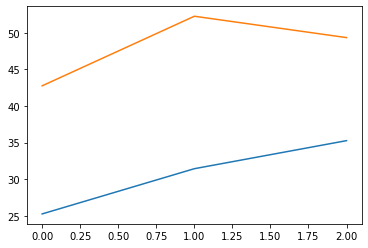

In [15]:
plt.plot(train_acc)
plt.plot(test_acc)

In [10]:
from model.gradcam.utils import plot_gradcam

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
target_layers = ["layer1", "layer2", "layer3", "layer4"]
mean = (0.491, 0.482, 0.446)
std = (0.247, 0.243, 0.261)

plot_gradcam(target_layers, device, testloader, model, mean, std, class_names)

NameError: name &#39;AugmentationFactoryBase&#39; is not defined

In [11]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [16]:
!nvidia-smi


&#39;nvidia-smi&#39; is not recognized as an internal or external command,
operable program or batch file.
